In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving als_hx.csv to als_hx (1).csv
Saving ALSFRS_orig.csv to ALSFRS_orig.csv
Saving ALSFRS_rev.csv to ALSFRS_rev (1).csv
Saving demographic.csv to demographic (1).csv
Saving fvc.csv to fvc (1).csv
Saving lab.csv to lab (1).csv
Saving survival.csv to survival (1).csv
Saving weight.csv to weight (1).csv


In [33]:
# import raw data
import io
demographics = pd.read_csv(io.BytesIO(uploaded['demographic.csv']))
als_hx = pd.read_csv(io.BytesIO(uploaded['als_hx.csv']))
lab = pd.read_csv(io.BytesIO(uploaded['lab.csv']))
weight = pd.read_csv(io.BytesIO(uploaded['weight.csv']))
alsfrs_R_raw = pd.read_csv(io.BytesIO(uploaded['ALSFRS_rev.csv']))
alsfrs_raw = pd.read_csv(io.BytesIO(uploaded['ALSFRS_orig.csv']))
fvc = pd.read_csv(io.BytesIO(uploaded['fvc.csv']))
surv = pd.read_csv(io.BytesIO(uploaded['survival.csv']))

# 1. Extracting feature variables

## 1-1. Static features

### (1) Age/Gender (Demographics)

In [5]:
demographics = demographics[['SubjectID', 'Age', 'Gender']]

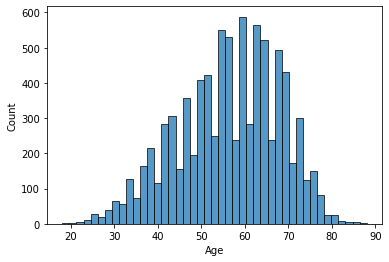

In [6]:
sns.histplot(demographics['Age'])

In [7]:
demographics['Age'].describe() # min = 18, max = 88

count    8646.000000
mean       56.255957
std        11.633752
min        18.000000
25%        48.000000
50%        57.000000
75%        65.000000
max        88.000000
Name: Age, dtype: float64

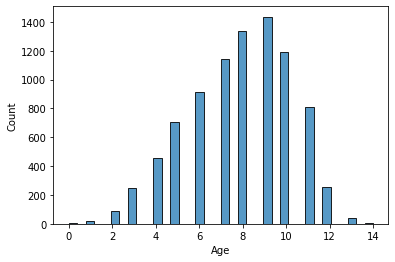

In [8]:
# Convert 'Age' into ordered-categorical data (categorize in  5 years)
age_min = 15 

def cat_age(age, age_min):
  return (age - age_min) // 5

demographics['Age'] = demographics.apply(lambda x: cat_age(x['Age'], age_min), axis = 1)
sns.histplot(demographics['Age'])

In [9]:
# Female = 0, Male = 1
demographics = demographics.replace({'Gender':{"F":0, "M":1}})
demographics #8653 data

,SubjectID,Age,Gender
0,329,4.0,0.0
1,348,7.0,0.0
2,533,10.0,0.0
3,586,9.0,1.0
4,649,6.0,0.0
...,...,...,...
8648,999823,8.0,1.0
8649,999863,12.0,1.0
8650,999880,7.0,1.0
8651,999929,8.0,1.0


### (2) diag_delta/onset_delta/diag_minus_onset/onset_site (ALS history)

In [10]:
als_hx = als_hx[['SubjectID', 'diag_delta', 'onset_delta', 'onset_site']]
als_hx['diag_minus_onset'] = als_hx['diag_delta']-als_hx['onset_delta'] #define 'diag_minus_onset' as time difference between onset and diagnosis

In [11]:
# Convert scale 'days' to 'month'
als_hx['diag_delta'] = als_hx['diag_delta']/(365/12)
als_hx['onset_delta'] = als_hx['onset_delta']/(365/12)
als_hx['diag_minus_onset'] = als_hx['diag_minus_onset']/(365/12)

# Bubar_onset = 1, non-Bulbar_onset = 0
als_hx = als_hx.replace({'onset_site':{"Other":0, "Bulbar":1, "Limb":0, "Limb and Bulbar":1}}) #Multifocal onset is included in bubar onset
als_hx #4454 data (no change)

,SubjectID,diag_delta,onset_delta,onset_site,diag_minus_onset
0,329,-35.112329,-56.087671,0.0,20.975342
1,348,-9.928767,-16.471233,0.0,6.542466
2,533,-1.446575,-33.632877,1.0,32.186301
3,586,-16.668493,-23.506849,1.0,6.838356
4,708,-32.416438,-35.178082,1.0,2.761644
...,...,...,...,...,...
4449,999761,-6.608219,-23.572603,0.0,16.964384
4450,999823,-2.761644,-16.175342,0.0,13.413699
4451,999880,-69.205479,-94.191781,0.0,24.986301
4452,999929,-3.517808,-13.512329,0.0,9.994521


## 1-2. Time-resolved features

In [12]:
# Define function calculating mean
def cal_mean(df):
  df_mean = df.groupby('SubjectID').agg('mean')
  df_mean.reset_index(inplace=True) # reset 'SubjectiD' as column
  
  mean_df = pd.DataFrame(df_mean['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    mean_df['mean_'+feature] = df_mean[feature]

  return mean_df

In [13]:
# Define function calculating slope
def cal_slope(df):
  df_first_last = df.groupby('SubjectID').agg(['first', 'last'])
  df_first_last.reset_index(inplace=True) # reset 'SubjectiD' as column
  df_first_last['interval'] = df_first_last[('feature_delta','last')] - df_first_last[('feature_delta','first')]
  df_first_last = df_first_last[df_first_last['interval']!=0] # exclude data that is observed only once

  slope_df = pd.DataFrame(df_first_last['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    slope_df['slope_'+feature] = df_first_last.apply(lambda x: (x[(feature,'last')]-x[(feature, 'first')])/x[('interval','')] if x[('interval','')] >= 1.0 else np.nan, axis = 1)
    # data with time interval less than 1 month is regarded as missing data, otherwise calculate slope with data of (last, first) feature delta

  return slope_df

In [14]:
# Define function calculating for time-resolved features
def cal_time_resolved(df):
  # Filter first 3 month data
  df_3mo = df.query('(feature_delta <= 3.0) and (feature_delta >= 0)')

  # Calculate mean
  mean_df = cal_mean(df_3mo)

  # Calculate slope
  slope_df = cal_slope(df_3mo)
  
  # Merge mean & slope data
  df_summary =  mean_df.merge(slope_df, on = 'SubjectID', how='outer')

  return df_summary

### (1) alsfrs_r (total/3 dimension/q) for train/test data

In [15]:
alsfrs_R_raw1 = alsfrs_R_raw[['SubjectID', 'feature_delta', 'ALSFRS_R_Total', 'Q1_Speech',
       'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5_Cutting',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea',
       'R3_Respiratory_Insufficiency', 'bulbar', 'motor', 'respiratory']]

# Q2 score was excluded from bulbar score because salivation can be easily affected by drug usage
alsfrs_R_raw1['bulbar'] = alsfrs_R_raw1['bulbar'] - alsfrs_R_raw1['Q2_Salivation']

# Calculate
alsfrs_R_summary = cal_time_resolved(alsfrs_R_raw1)
alsfrs_R_summary #3058 data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SubjectID,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory
0,348,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.00,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.0,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000
1,533,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.00,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.0,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000
2,586,39.000000,0.000000,2.000000,1.00,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,1.000000,24.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,902,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.00,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.0,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319
4,1064,40.000000,0.750000,2.750000,0.75,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,3.75,4.000000,4.000000,1.500000,24.000000,11.750000,-1.321586,0.000000,-0.440529,-0.440529,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.440529,0.000000,0.000000,-0.440529,0.000000,-0.440529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053,998542,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.50,4.000000,4.000000,8.000000,14.000000,10.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3054,998756,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.00,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519
3055,999166,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.00,4.000000,4.000000,7.000000,21.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3056,999823,43.250000,2.750000,3.000000,2.75,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,12.000000,-0.743494,-0.371747,0.000000,-0.371747,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.743494,0.000000,0.000000


### (2) FVC

In [16]:
fvc

,SubjectID,feature_name,feature_value,feature_delta
0,329,fvc_percent,98,0.00
1,329,fvc_percent,103,0.53
2,329,fvc_percent,101,1.38
3,329,fvc_percent,103,2.37
4,329,fvc_percent,93,4.44
...,...,...,...,...
21284,992712,fvc_percent,89,4.37
21285,992712,fvc_percent,90,7.99
21286,992712,fvc_percent,85,11.47
21287,992712,fvc_percent,85,15.85


In [17]:
fvc[['feature_name']].describe()

,feature_name
count,21289
unique,1
top,fvc_percent
freq,21289


In [18]:
fvc1 = fvc[['SubjectID', 'feature_value', 'feature_delta']]
fvc1.columns = ['SubjectID', 'fvc', 'feature_delta']

# Calculate
fvc_summary = cal_time_resolved(fvc1)
fvc_summary # 3403 data

,SubjectID,mean_fvc,slope_fvc
0,329,101.250000,2.109705
1,533,73.500000,NaN
2,586,26.000000,NaN
3,708,51.000000,-2.415459
4,902,89.600000,-1.003344
...,...,...,...
3398,998756,73.333333,-7.826087
3399,999166,75.000000,NaN
3400,999823,100.800000,-0.334448
3401,999880,50.250000,-2.173913


### (3) Creatinine

In [19]:
creatinine = lab[['SubjectID', 'feature_delta', 'Creatinine']]

In [20]:
# Check string value
creatinine[creatinine['Creatinine']=='<18'] #There are 0 subjects with string value '<18'

,SubjectID,feature_delta,Creatinine


In [21]:
# Remove string value and change into float datatype
# No need to care about this process because new data was already cleansed 

In [22]:
# Calculate
creatinine_summary = cal_time_resolved(creatinine)
creatinine_summary # 3781 data

,SubjectID,mean_Creatinine,slope_Creatinine
0,329,58.933333,-37.299578
1,348,53.040000,0.000000
2,533,79.560000,0.000000
3,708,88.400000,0.000000
4,1064,70.720000,0.000000
...,...,...,...
3776,998542,53.040000,NaN
3777,998756,88.400000,NaN
3778,999166,83.980000,5.854305
3779,999880,88.400000,0.000000


### (4) Weight

In [23]:
# Calculate 
weight_summary = cal_time_resolved(weight)
weight_summary # 4183 data

,SubjectID,mean_weight,slope_weight
0,329,50.380000,-2.700422
1,348,120.033333,1.840796
2,533,51.000000,-0.167224
3,586,61.800000,NaN
4,708,60.450000,-3.311037
...,...,...,...
4178,999761,91.350000,-0.167224
4179,999823,70.460000,-0.535117
4180,999880,68.000000,-0.217391
4181,999929,67.900000,-2.101449


## 1-3. Merging all features

In [24]:
features_without_alsfrs = pd.DataFrame(columns=['SubjectID'])
feature_list = [demographics, als_hx, fvc_summary, creatinine_summary, weight_summary]
for i in feature_list :
    df = i
    features_without_alsfrs = features_without_alsfrs.merge(df, on='SubjectID', how='outer')
features_without_alsfrs #8653 data

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight
0,329,4.0,0.0,-35.112329,-56.087671,0.0,20.975342,101.25,2.109705,58.933333,-37.299578,50.380000,-2.700422
1,348,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,NaN,NaN,53.040000,0.000000,120.033333,1.840796
2,533,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.50,NaN,79.560000,0.000000,51.000000,-0.167224
3,586,9.0,1.0,-16.668493,-23.506849,1.0,6.838356,26.00,NaN,NaN,NaN,61.800000,NaN
4,649,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8648,999823,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.80,-0.334448,NaN,NaN,70.460000,-0.535117
8649,999863,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8650,999880,7.0,1.0,-69.205479,-94.191781,0.0,24.986301,50.25,-2.173913,88.400000,0.000000,68.000000,-0.217391
8651,999929,8.0,1.0,-3.517808,-13.512329,0.0,9.994521,NaN,NaN,NaN,NaN,67.900000,-2.101449


In [25]:
# features_with_alsfrs_R is for train/test data
features_with_alsfrs_R = features_without_alsfrs.merge(alsfrs_R_summary, on='SubjectID', how = 'inner')
features_with_alsfrs_R #3058 data

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory
0,348,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,NaN,NaN,53.04,0.000000,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.00,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.0,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000
1,533,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,NaN,79.56,0.000000,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.00,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.0,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000
2,586,9.0,1.0,-16.668493,-23.506849,1.0,6.838356,26.000000,NaN,NaN,NaN,61.800000,NaN,39.000000,0.000000,2.000000,1.00,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,1.000000,24.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,902,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,-1.003344,NaN,NaN,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.00,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.0,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319
4,1064,10.0,0.0,-15.189041,-18.082192,1.0,2.893151,NaN,NaN,70.72,0.000000,80.700000,-0.616740,40.000000,0.750000,2.750000,0.75,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,3.75,4.000000,4.000000,1.500000,24.000000,11.750000,-1.321586,0.000000,-0.440529,-0.440529,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.440529,0.000000,0.000000,-0.440529,0.000000,-0.440529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053,998542,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,NaN,53.04,NaN,72.400000,NaN,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.50,4.000000,4.000000,8.000000,14.000000,10.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3054,998756,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,-7.826087,88.40,NaN,70.200000,NaN,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.00,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519
3055,999166,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,NaN,83.98,5.854305,84.750000,NaN,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.00,4.000000,4.000000,7.000000,21.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3056,999823,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.800000,-0.334448,NaN,NaN,70.460000,-0.535117,43.250000,2.750000,3.000000,2.75,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,12.000000,-0.743494,-0.371747,0.000000,-0.371747,0.000000,0

In [26]:
subjects_with_feature = list(features_with_alsfrs_R['SubjectID'])

# 2. Extracting target variables

## 2-1. Optimal target (Q3 becoming 1.0)

### (1) Subtracting [initial Q3 score <=1 ]

In [37]:
alsfrs_filtered = alsfrs_raw.query("SubjectID == {0}".format(subjects_with_feature))

In [38]:
len(alsfrs_filtered['SubjectID'].unique())

3058

In [39]:
alsfrs_Sw = alsfrs_filtered[['SubjectID', 'feature_delta', 'Q3_Swallowing']].reindex(columns=['SubjectID', 'Q3_Swallowing', 'feature_delta'])
alsfrs_Sw = alsfrs_Sw[alsfrs_Sw['feature_delta']>=0]
alsfrs_Sw 

,SubjectID,Q3_Swallowing,feature_delta
0,100256,4.0,0.00
1,100256,4.0,0.33
2,100256,4.0,3.29
3,100256,3.0,6.21
4,100256,4.0,9.21
...,...,...,...
36966,999990,4.0,0.39
36967,999990,4.0,1.32
36968,999990,4.0,2.24
36969,999990,3.0,3.19


In [40]:
alsfrs_Sw_grouped = alsfrs_Sw.groupby('SubjectID').agg(['first', 'last'])
alsfrs_Sw_grouped = alsfrs_Sw_grouped.reset_index()
alsfrs_Sw_grouped = alsfrs_Sw_grouped[alsfrs_Sw_grouped[('feature_delta', 'last')]!= alsfrs_Sw_grouped[('feature_delta', 'first')]] # more than 2 observation needed (score chagnes from above 2 to 2)
alsfrs_filtered_extent = list(alsfrs_Sw_grouped[alsfrs_Sw_grouped[('Q3_Swallowing','first')]>1.0].reset_index()['SubjectID']) # initial ALSFRS Q3 > 1

In [41]:
# Subtract [first ALSFRS Q3 <=1.0] & [ALSFRS Q3 observed only once]
alsfrs_Sw_filtered = alsfrs_Sw.query("SubjectID == {0}".format(alsfrs_filtered_extent))
alsfrs_Sw_filtered

,SubjectID,Q3_Swallowing,feature_delta
0,100256,4.0,0.00
1,100256,4.0,0.33
2,100256,4.0,3.29
3,100256,3.0,6.21
4,100256,4.0,9.21
...,...,...,...
36966,999990,4.0,0.39
36967,999990,4.0,1.32
36968,999990,4.0,2.24
36969,999990,3.0,3.19


### (2) Time of [Q3 score == 1.0]

In [42]:
# Find the first time of [ALSFRS_Q3 <= 1.0]
Optimal_event = alsfrs_Sw_filtered[alsfrs_Sw_filtered['Q3_Swallowing']<=1].groupby('SubjectID').agg(['first']).reset_index()

In [43]:
# Coding [ALSFRS-Q3<=1] event as '1'
Optimal_event_1 = Optimal_event[[(    'SubjectID',      ''), ('feature_delta', 'first')]]
Optimal_event_1.columns = ['SubjectID', 'time_opt']

Optimal_event_1_sublist = list(Optimal_event['SubjectID'])

Optimal_event_1['status_opt'] = 1
print("There are",len(Optimal_event_1['SubjectID'].unique()), "subjects whose status_opt = 1")

# Otherwise '0'
Optimal_event_0 = alsfrs_Sw_filtered[~alsfrs_Sw_filtered['SubjectID'].isin(Optimal_event_1_sublist)]
Optimal_event_0 = Optimal_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('Q3_Swallowing', 'last'))
Optimal_event_0.columns = ['SubjectID', 'time_opt']
Optimal_event_0['status_opt'] = 0
print("There are",len(Optimal_event_0['SubjectID'].unique()), "subjects whose status_opt = 0")
 # There are 629 subjects whose status_opt = 1
 # There are 2198 subjects whose status_opt = 0

There are 629 subjects whose status_opt = 1
There are 2198 subjects whose status_opt = 0


In [44]:
alsfrs_Sw_coded = pd.concat([Optimal_event_1, Optimal_event_0]).sort_values(by='SubjectID', axis=0)
alsfrs_Sw_coded = alsfrs_Sw_coded.reset_index()
alsfrs_Sw_coded.drop(columns='index', inplace=True)

Optimal_Gas = alsfrs_Sw_coded.copy()
sub_list = list(Optimal_Gas['SubjectID'])
Optimal_Gas #2827 data

,SubjectID,time_opt,status_opt
0,348,13.18,0
1,533,9.44,1
2,902,5.06,0
3,1736,8.02,1
4,3971,12.43,0
...,...,...,...
2822,998542,0.26,0
2823,998756,2.10,0
2824,999166,12.82,0
2825,999823,6.05,0


In [45]:
Optimal_Gas.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_optimal_target.csv')

In [46]:
# Be aware that 'time_opt' is month scaled

## 2-2. Real target

### (1) Time of [ALSFRS Q5_b != NaN]

In [ ]:
gastro = alsfrs_filtered[['SubjectID', 'Gastrostomy', 'feature_delta']].sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
gastro.replace({'Gastrostomy':{False:np.nan}}, inplace=True)
gastro

,SubjectID,Gastrostomy,feature_delta
0,348,NaN,0.00
1,348,NaN,0.13
2,348,NaN,1.71
3,348,NaN,2.01
4,348,NaN,3.25
...,...,...,...
28056,999990,NaN,0.39
28057,999990,NaN,1.32
28058,999990,NaN,2.24
28059,999990,NaN,3.19


In [ ]:
gastro.isnull().sum()

SubjectID            0
Gastrostomy      21557
feature_delta        0
dtype: int64

In [ ]:
# Check censored data
def checking_censored(x):
  
  if x.isnull().sum() == 0:
    return "Left censored"
  elif x.notnull().sum() == 0:
    return "Right censored"
  else:
    return "Normal"

aggs_by_col = {'Gastrostomy': [checking_censored], 'feature_delta': ['last']}
gastro_a = gastro.groupby('SubjectID', as_index=False).agg(aggs_by_col)
gastro_a

,SubjectID,Gastrostomy,feature_delta
,,checking_censored,last
0,348,Right censored,13.18
1,533,Normal,12.43
2,586,Right censored,0.10
3,902,Left censored,5.06
4,1064,Normal,14.27
...,...,...,...
3053,998542,Right censored,0.26
3054,998756,Right censored,2.10
3055,999166,Right censored,12.82


In [ ]:
#Subtract Left censored data

gastro_a.columns = ['SubjectID', 'checking_censored', 'last_feature_delta']
gastro_a = gastro_a[gastro_a['checking_censored'] != 'Left censored']
full_extent = list(gastro_a['SubjectID'])
Right_censored_extent = list(gastro_a[gastro_a['checking_censored'] == 'Right censored']['SubjectID'])
Normal_extent = list(gastro_a[gastro_a['checking_censored'] == 'Normal']['SubjectID'])

print("Total number is " + str(len(full_extent))) # Total number is 2530
print("There are " + str(len(Right_censored_extent)) + " right censored data") # There are 1874 right censored data
print("There are " + str(len(Normal_extent)) + " normal data") # There are 656 normal data

Total number is 2530
There are 1874 right censored data
There are 656 normal data


In [ ]:
# Create gastro_event_0
gastro_event_0 = gastro_a[gastro_a['checking_censored'] == 'Right censored']
gastro_event_0 = gastro_event_0.replace({'checking_censored':{'Right censored': 0}})
gastro_event_0.columns = ['SubjectID', 'status', 'time']
gastro_event_0 = gastro_event_0[gastro_event_0['time'] != 0] # time != 0 
gastro_event_0 #1866 data

,SubjectID,status,time
0,348,0,13.18
2,586,0,0.10
7,2416,0,0.07
9,3971,0,12.43
10,4752,0,12.69
...,...,...,...
3052,998019,0,0.43
3053,998542,0,0.26
3054,998756,0,2.10
3055,999166,0,12.82


In [ ]:
# Create gastro_event_1
gastro_b = gastro.copy()
gastro_b.query("SubjectID == {0}".format(Normal_extent), inplace=True)
gastro_b = gastro_b.dropna(axis=0)
gastro_event_1 = pd.DataFrame(gastro_b.groupby('SubjectID')['feature_delta'].agg('first')).reset_index()
gastro_event_1.columns = ['SubjectID', 'time']
gastro_event_1['status'] = 1
gastro_event_1 = gastro_event_1[gastro_event_1['time'] != 0] # time != 0 
gastro_event_1 #442 data

,SubjectID,time,status
0,533,9.44,1
4,6483,3.22,1
5,7036,4.08,1
6,7750,12.66,1
7,8150,9.96,1
...,...,...,...
650,991820,1.38,1
651,992110,15.39,1
653,994895,6.28,1
654,995893,5.75,1


In [ ]:
gastro_fin = pd.concat([gastro_event_1, gastro_event_0]).sort_values(by='SubjectID', axis=0)
gastro_fin = gastro_fin.reset_index().drop(columns = 'index')
gastro_fin.columns = ['SubjectID', 'time_real', 'status_real']
Real_Gas = gastro_fin.copy()
Real_Gas # 2308 data

,SubjectID,time_real,status_real
0,348,13.18,0
1,533,9.44,1
2,586,0.10,0
3,2416,0.07,0
4,3971,12.43,0
...,...,...,...
2303,998019,0.43,0
2304,998542,0.26,0
2305,998756,2.10,0
2306,999166,12.82,0


In [ ]:
Real_Gas.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_real_target.csv')

## 2-3. Comparing proportion of censored data in Optimal gas/ Real gas / Survival

In [ ]:
event_distribution = pd.DataFrame(Optimal_Gas[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status_o', 'count']
event_distribution['status_o'] = event_distribution['status_o'].astype('bool')
event_distribution = event_distribution.replace({'status_o': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)

event_distribution_2 = pd.DataFrame(surv[['status']].value_counts()).reset_index()
event_distribution_2.columns = ['status_surv', 'count']
event_distribution_2['status_surv'] = event_distribution_2['status_surv'].astype('bool')
event_distribution_2 = event_distribution_2.replace({'status_surv': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_2)

event_distribution_3 = pd.DataFrame(Real_Gas[['status_real']].value_counts()).reset_index()
event_distribution_3.columns = ['status_real', 'count']
event_distribution_3['status_real'] = event_distribution_3['status_real'].astype('bool')
event_distribution_3 = event_distribution_3.replace({'status_real': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_3)

A_1 = event_distribution.iloc[0]['count']
B_1 = event_distribution.iloc[1]['count']
per_0 = str(round((A_1/(A_1+B_1))*100,2))+"%"
per_1 = str(round((B_1/(A_1+B_1))*100,2))+'%'

A = event_distribution_2.iloc[0]['count']
B = event_distribution_2.iloc[1]['count']
perc_0 = str(round((A/(A+B))*100,2))+"%"
perc_1 = str(round((B/(A+B))*100,2))+'%'

A_2 = event_distribution_3.iloc[0]['count']
B_2 = event_distribution_3.iloc[1]['count']
pe_0 = str(round((A_2/(A_2+B_2))*100,2))+"%"
pe_1 = str(round((B_2/(A_2+B_2))*100,2))+'%'


#        status_o  count
# 0  0 (censored)   2198
# 1   1 (occured)    629
#     status_surv  count
# 0  0 (censored)   6005
# 1   1 (occured)   3075
#     status_real  count
# 0  0 (censored)   1866
# 1   1 (occured)    442


       status_o  count
0  0 (censored)   2198
1   1 (occured)    629
    status_surv  count
0  0 (censored)   6005
1   1 (occured)   3075
    status_real  count
0  0 (censored)   1866
1   1 (occured)    442


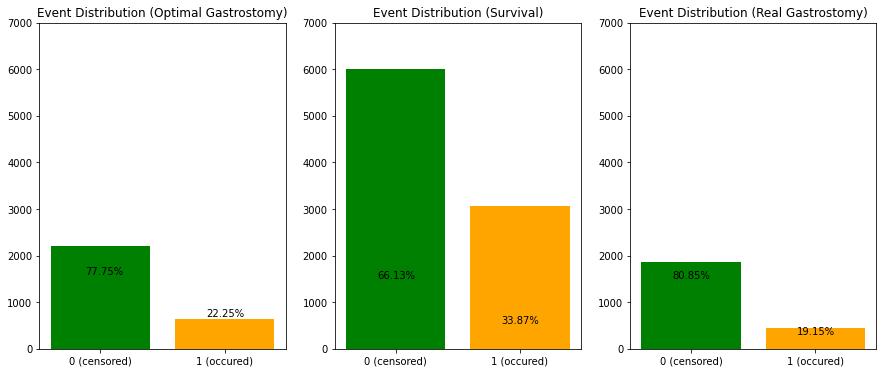

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.bar(event_distribution['status_o'], height=event_distribution['count'], color=['green', 'orange'])
plt.ylim([0,7000])
plt.title('Event Distribution (Optimal Gastrostomy)')
plt.text(-0.12,1600,per_0)
plt.text(0.85,700,per_1)

plt.subplot(132)
plt.bar(event_distribution_2['status_surv'], height=event_distribution_2['count'], color=['green', 'orange'])
plt.ylim([0,7000])
plt.title('Event Distribution (Survival)')
plt.text(-0.15,1500,perc_0)
plt.text(0.85,550,perc_1)

plt.subplot(133)
plt.bar(event_distribution_3['status_real'], height=event_distribution_3['count'], color=['green', 'orange'])
plt.ylim([0,7000])
plt.title('Event Distribution (Real Gastrostomy)')
plt.text(-0.15,1500,pe_0)
plt.text(0.85,300,pe_1)

plt.show()

# 전반적으로 샘플수는 줄었으나 censored data의 비율이 지난번보다 조금 낮아짐.

# 3. Merging feature and target & Imputation

## 3-1 Inner-join feature and target

In [47]:
features_with_alsfrs_R # 3058 data

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory
0,348,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,NaN,NaN,53.04,0.000000,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.00,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.0,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000
1,533,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,NaN,79.56,0.000000,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.00,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.0,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000
2,586,9.0,1.0,-16.668493,-23.506849,1.0,6.838356,26.000000,NaN,NaN,NaN,61.800000,NaN,39.000000,0.000000,2.000000,1.00,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,1.000000,24.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,902,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,-1.003344,NaN,NaN,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.00,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.0,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319
4,1064,10.0,0.0,-15.189041,-18.082192,1.0,2.893151,NaN,NaN,70.72,0.000000,80.700000,-0.616740,40.000000,0.750000,2.750000,0.75,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,3.75,4.000000,4.000000,1.500000,24.000000,11.750000,-1.321586,0.000000,-0.440529,-0.440529,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.440529,0.000000,0.000000,-0.440529,0.000000,-0.440529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053,998542,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,NaN,53.04,NaN,72.400000,NaN,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.50,4.000000,4.000000,8.000000,14.000000,10.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3054,998756,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,-7.826087,88.40,NaN,70.200000,NaN,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.00,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519
3055,999166,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,NaN,83.98,5.854305,84.750000,NaN,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.00,4.000000,4.000000,7.000000,21.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3056,999823,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.800000,-0.334448,NaN,NaN,70.460000,-0.535117,43.250000,2.750000,3.000000,2.75,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,12.000000,-0.743494,-0.371747,0.000000,-0.371747,0.000000,0

In [48]:
Optimal_Gas # 3796-->2827 data

,SubjectID,time_opt,status_opt
0,348,13.18,0
1,533,9.44,1
2,902,5.06,0
3,1736,8.02,1
4,3971,12.43,0
...,...,...,...
2822,998542,0.26,0
2823,998756,2.10,0
2824,999166,12.82,0
2825,999823,6.05,0


In [49]:
X_y_NaN = pd.merge(features_with_alsfrs_R, Optimal_Gas, on = 'SubjectID')
X_y_NaN # 2827 data

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,348,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,NaN,NaN,53.04,0.000000,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.0,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.0,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000,13.18,0
1,533,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,NaN,79.56,0.000000,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.0,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.0,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000,9.44,1
2,902,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,-1.003344,NaN,NaN,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.0,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.0,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319,5.06,0
3,1736,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,0.000000,58.40,0.000000,121.400000,NaN,24.500000,2.500000,3.000000,3.00,1.500000,1.00,1.000000,0.500000,0.500000,0.000000,3.5,4.000000,4.000000,5.500000,4.500000,11.500000,-3.164557,-0.632911,-1.265823,0.000000,-0.632911,0.0,0.000000,-0.632911,-0.632911,0.000000,0.632911,0.000000,0.000000,-0.632911,-1.898734,0.632911,8.02,1
4,3971,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,NaN,53.04,NaN,88.900000,-1.250000,38.000000,4.000000,4.000000,4.00,4.000000,4.00,2.000000,3.000000,1.000000,0.000000,4.0,4.000000,4.000000,8.000000,14.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,998542,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,NaN,53.04,NaN,72.400000,NaN,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.5,4.000000,4.000000,8.000000,14.000000,10.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26,0
2823,998756,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,-7.826087,88.40,NaN,70.200000,NaN,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.0,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519,2.10,0
2824,999166,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,NaN,83.98,5.854305,84.750000,NaN,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.0,4.000000,4.000000,7.000000,21.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.82,0
2825,999823,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.800000,-0.334448,NaN,NaN,70.460000,-0.535117,43.250000,2.750000,3.000000,2.75,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.0,4.

## 3-2. Check NaN proportion 

### (1) Check NaN proportion in features for train data

The column mean_fvc has 681 null values. It is 24.09% of total rows.
The column mean_fvc is of type float64.

The column slope_fvc has 1392 null values. It is 49.24% of total rows.
The column slope_fvc is of type float64.

The column mean_Creatinine has 288 null values. It is 10.19% of total rows.
The column mean_Creatinine is of type float64.

The column slope_Creatinine has 1195 null values. It is 42.27% of total rows.
The column slope_Creatinine is of type float64.

The column mean_weight has 211 null values. It is 7.46% of total rows.
The column mean_weight is of type float64.

The column slope_weight has 860 null values. It is 30.42% of total rows.
The column slope_weight is of type float64.

The column slope_ALSFRS_R_Total has 333 null values. It is 11.78% of total rows.
The column slope_ALSFRS_R_Total is of type float64.

The column slope_Q1_Speech has 333 null values. It is 11.78% of total rows.
The column slope_Q1_Speech is of type float64.

The column slope_Q2_Salivation has 

[]

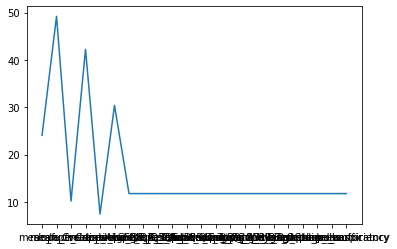

In [ ]:
def report_nulls(df):
    '''
    Show a fast report of the DF.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    list_of_nulls_cols_pcn = []
    list_of_nulls_cols_over60 = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            list_of_nulls_cols_pcn.append(null_rows_pcn)
            if null_rows_pcn > 60:
                list_of_nulls_cols_over60.append(col)
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    plt.plot(list_of_nulls_cols, list_of_nulls_cols_pcn)
    return list_of_nulls_cols_over60

report_nulls(X_y_NaN) 

In [ ]:
X_y_NaN.isnull().sum()

SubjectID                                0
Age                                      0
Gender                                   0
diag_delta                               0
onset_delta                              0
onset_site                               0
diag_minus_onset                         0
mean_fvc                               681
slope_fvc                             1392
mean_Creatinine                        288
slope_Creatinine                      1195
mean_weight                            211
slope_weight                           860
mean_ALSFRS_R_Total                      0
mean_Q1_Speech                           0
mean_Q2_Salivation                       0
mean_Q3_Swallowing                       0
mean_Q4_Handwriting                      0
mean_Q5_Cutting                          0
mean_Q6_Dressing_and_Hygiene             0
mean_Q7_Turning_in_Bed                   0
mean_Q8_Walking                          0
mean_Q9_Climbing_Stairs                  0
mean_R1_Dys

In [ ]:
#Create df for showing NaN pattern
feature_nan_pattern1 = X_y_NaN[['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_Q1_Speech','slope_Q1_Speech', 'mean_fvc', 'slope_fvc', 'mean_Creatinine',
       'slope_Creatinine', 'mean_weight','slope_weight']]
feature_nan_pattern1.columns = ['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_ALSFRS','slope_ALSFRS', 'mean_fvc', 'slope_fvc', 'mean_Creatinine',
       'slope_Creatinine', 'mean_weight','slope_weight']

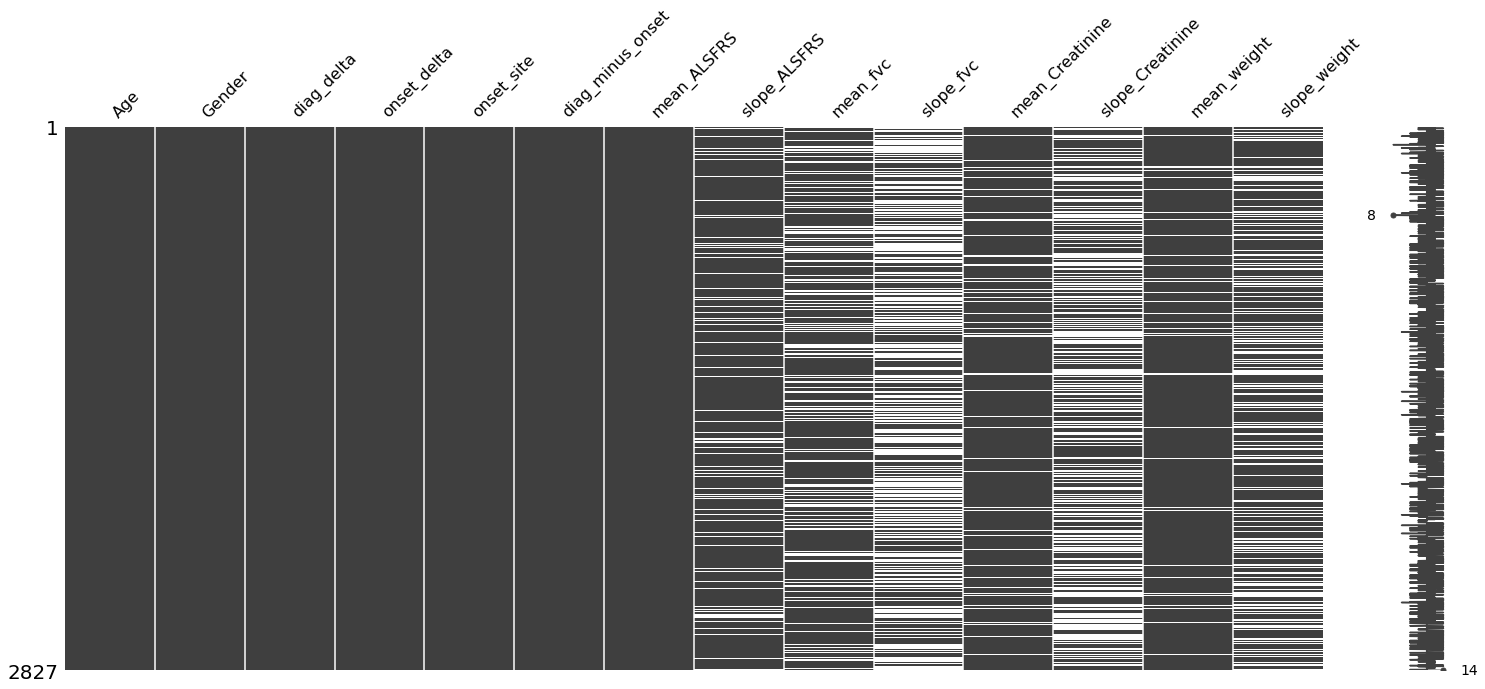

In [ ]:
# Nullity matrix
import missingno as msno
msno.matrix(feature_nan_pattern1)

In [50]:
# Exclude 'slope_fvc', 'slope_Creatinine' in feature list because it's NaN proportion is over 40% 
X_y_NaN = X_y_NaN.drop(columns = ['slope_fvc', 'slope_Creatinine'])

In [52]:
X_y_NaN.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_X_y_NaN_whole.csv')

## 3-3. Data imputation

### (1) Train data

In [ ]:
# Split Train/Test in 8:2 생략

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
X_y_NaN

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,348,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,NaN,53.04,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.0,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.0,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000,13.18,0
1,533,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,79.56,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.0,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.0,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000,9.44,1
2,902,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,NaN,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.0,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.0,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319,5.06,0
3,1736,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,58.40,121.400000,NaN,24.500000,2.500000,3.000000,3.00,1.500000,1.00,1.000000,0.500000,0.500000,0.000000,3.5,4.000000,4.000000,5.500000,4.500000,11.500000,-3.164557,-0.632911,-1.265823,0.000000,-0.632911,0.0,0.000000,-0.632911,-0.632911,0.000000,0.632911,0.000000,0.000000,-0.632911,-1.898734,0.632911,8.02,1
4,3971,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,53.04,88.900000,-1.250000,38.000000,4.000000,4.000000,4.00,4.000000,4.00,2.000000,3.000000,1.000000,0.000000,4.0,4.000000,4.000000,8.000000,14.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,998542,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,53.04,72.400000,NaN,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.5,4.000000,4.000000,8.000000,14.000000,10.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26,0
2823,998756,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,88.40,70.200000,NaN,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.0,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519,2.10,0
2824,999166,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,83.98,84.750000,NaN,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.0,4.000000,4.000000,7.000000,21.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.82,0
2825,999823,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,100.800000,NaN,70.460000,-0.535117,43.250000,2.750000,3.000000,2.75,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,5.500000,22.750000,12.000000,-0.743494,-0.371747,0.000000,-0.371747,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
# Imputation with IterativeImputer
X_y_NaN = X_y_NaN.drop(['time_opt', 'status_opt'], axis = 1)
columns = X_y_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_y_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_imputed = pd.merge(X_imputed, Optimal_Gas, on = 'SubjectID')
X_y_imputed

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,348.0,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,70.157760,53.040000,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.0,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.000000,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000,13.18,0
1,533.0,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,79.560000,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.0,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.000000,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000,9.44,1
2,902.0,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,58.204386,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.0,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.000000,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319,5.06,0
3,1736.0,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,58.400000,121.400000,-1.280075,24.500000,2.500000,3.000000,3.00,1.500000,1.00,1.000000,0.500000,0.500000,0.000000,3.5,4.000000,4.000000,5.500000,4.500000,11.500000,-3.164557,-0.632911,-1.265823,0.000000,-0.632911,0.000000,0.000000,-0.632911,-0.632911,0.000000,0.632911,0.000000,0.000000,-0.632911,-1.898734,0.632911,8.02,1
4,3971.0,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,53.040000,88.900000,-1.250000,38.000000,4.000000,4.000000,4.00,4.000000,4.00,2.000000,3.000000,1.000000,0.000000,4.0,4.000000,4.000000,8.000000,14.000000,12.000000,-0.896762,-0.054849,-0.041205,-0.040174,-0.084564,-0.114611,-0.118540,-0.099158,-0.080400,-0.133462,-0.067174,-0.043216,-0.019409,-0.095040,-0.630737,-0.129774,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,998542.0,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,53.040000,72.400000,0.869153,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.5,4.000000,4.000000,8.000000,14.000000,10.500000,-0.896782,-0.054966,-0.041040,-0.040192,-0.084641,-0.114825,-0.118571,-0.098882,-0.080372,-0.133328,-0.067473,-0.042912,-0.019622,-0.095156,-0.630606,-0.129981,0.26,0
2823,998756.0,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,88.400000,70.200000,-3.461413,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.0,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519,2.10,0
2824,999166.0,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,83.980000,84.750000,0.871275,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.0,4.000000,4.000000,7.000000,21.000000,12.000000,-0.897026,-0.054800,-0.041330,-0.039904,-0.084610,-0.114890,-0.118634,-0.099186,-0.080250,-0.133307,-0.067

In [ ]:
X_y_imputed.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_X_y_imputed_whole.csv')